## Objective

In [ ]:
# Are you looking for to find optimal location for canola crush
# Are you looking to help an investment purposes
# 

Dependencies

In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import xarray as xr
from fuzzywuzzy import process


#Directories
general_directory = '/Users/Roy/Desktop/PaletteSkills/Stream-3__AI_ML_Doc/Palette_Cohort_7-main/Final-project/data/'

Canolla_weighted_avg_year_rm = pd.read_csv(general_directory+'Canolla_weighted_avg_year_rm.csv')

# # Reading Shapely
ShaplyGeoJason_Data = 'Shapely_GeoJason_Data/MUNICIPALITY.geojson'
gdf_rm = gpd.read_file(general_directory+ShaplyGeoJason_Data, engine="pyogrio")
gdf_rm=gdf_rm.rename(columns={'MUNI_LIST_NAME': 'RM'})

## GIS Visualization
def match_rms(rm, choices, limit=2):
    """Fuzzy match an RM name to the closest ones from a list of choices."""
    results = process.extract(rm, choices, limit=limit)
    return results[0]  # Return the best match

# List of RMs in df_yield_raw_3 to match against
yield_rms = Canolla_weighted_avg_year_rm['RM'].unique()

# Apply fuzzy matching for RMs in gdf_rm that are not found in df_yield_raw_3
gdf_rm['Matched_RM'] = gdf_rm['RM'].apply(lambda x: match_rms(x, yield_rms))

# Now check the matched results and scores
gdf_rm['Match_Score'] = gdf_rm['Matched_RM'].apply(lambda x: x[1])  # Get the match score
gdf_rm['Matched_RM'] = gdf_rm['Matched_RM'].apply(lambda x: x[0])   # Get the actual matched RM name

gdf_rm = gdf_rm.loc[:,['RM', 'geometry', 'Matched_RM', 'Match_Score']]

# Filter out 100% similarity
gdf_rm_filtered_Matched100 = gdf_rm[gdf_rm['Match_Score'] == 100]

gdf_rm_filtered_Matched95 = gdf_rm[(
                                (gdf_rm['Match_Score']>=95) &\
                                ((gdf_rm['Match_Score']<100))
                                )]

gdf_rm_filtered_Matched95['Matched_RM'] = gdf_rm_filtered_Matched95['RM']

gdf_rm_filtered = pd.concat([gdf_rm_filtered_Matched100,gdf_rm_filtered_Matched95])

yield_rms_Mod = gdf_rm_filtered['RM'].unique()

gdf_rm_filtered = gdf_rm_filtered.loc[:,['RM', 'geometry']]
gdf_rm_filtered = gpd.GeoDataFrame(gdf_rm_filtered)

# Apply fuzzy matching for RMs in gdf_rm that are not found in df_yield_raw_3
gdf_rm_filtered['Matched_RM'] = gdf_rm_filtered['RM'].apply(lambda x: match_rms(x, yield_rms_Mod))

# Now check the matched results and scores
gdf_rm_filtered['Match_Score'] = gdf_rm_filtered['Matched_RM'].apply(lambda x: x[1])  # Get the match score
gdf_rm_filtered['Matched_RM'] = gdf_rm_filtered['Matched_RM'].apply(lambda x: x[0])   # Get the actual matched RM name


# Filter out 100% similarity
gdf_rm_filtered_Matched100 = gdf_rm_filtered[gdf_rm_filtered['Match_Score'] == 100]
gdf_rm_filtered_MatchedNot100 = gdf_rm_filtered[gdf_rm_filtered['Match_Score'] < 100]

# Merge using the fuzzy matched RMs
merged_df_fuzz_Canolla = pd.merge(Canolla_weighted_avg_year_rm, gdf_rm_filtered, left_on='RM', right_on='Matched_RM', how='left')


merged_df_fuzz_Canolla = merged_df_fuzz_Canolla.loc[:,['Matched_RM', 'Match_Score',
       'Year', 'Crop','Weighted_Avg_Yield','Yield_Diff', 'Cluster', 'geometry']]

merged_df_fuzz_Canolla = merged_df_fuzz_Canolla[merged_df_fuzz_Canolla['Match_Score'] == 100]
merged_df_fuzz_Canolla.to_csv('merged_df_fuzz_Canolla.csv', index=False)

gdf_rm_yield_Canolla = merged_df_fuzz_Canolla.reset_index(drop=True)
gdf_rm_yield_Canolla = gpd.GeoDataFrame(gdf_rm_yield_Canolla)

#Function to create and display the map based on crop selection
def create_map(year):
    cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#FFFF00',  # Yellow
                  4: '#8A2BE2',  # Violet
                  5: '#d62728'}  # Red
    filtered_gdf_canolla = gdf_rm_yield_Canolla.loc[(gdf_rm_yield_Canolla['Year'] == year)]
    return filtered_gdf_canolla.explore(column='Cluster', 
                                        categorical=True,
                                        color=cluster_colors, 
                                        legend=True)

ListYearCanolla= sorted(Canolla_weighted_avg_year_rm['Year'].unique())


# Dropdown widget to select year
year_selector_canolla = widgets.Dropdown(
    options=ListYearCanolla,
    value=2023,
    description='Select Year:',
)


# Output widget to display the map
output = widgets.Output()

# Function to update the map when a different crop is selected
def update_map_Canolla(change):
    with output:
        output.clear_output()  # Clear previous map output
        m = create_map(year_selector_canolla.value)  # Generate the new map
        display(m)

# Trigger map update when the dropdown changes
year_selector_canolla.observe(update_map_Canolla, names='value')

# Display dropdown and initial map
display(year_selector_canolla)
update_map_Canolla(None)  # Initialize with the first map
display(output)








c:\Python38_64\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Dropdown(description='Select Year:', index=19, options=(2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, …

Output()

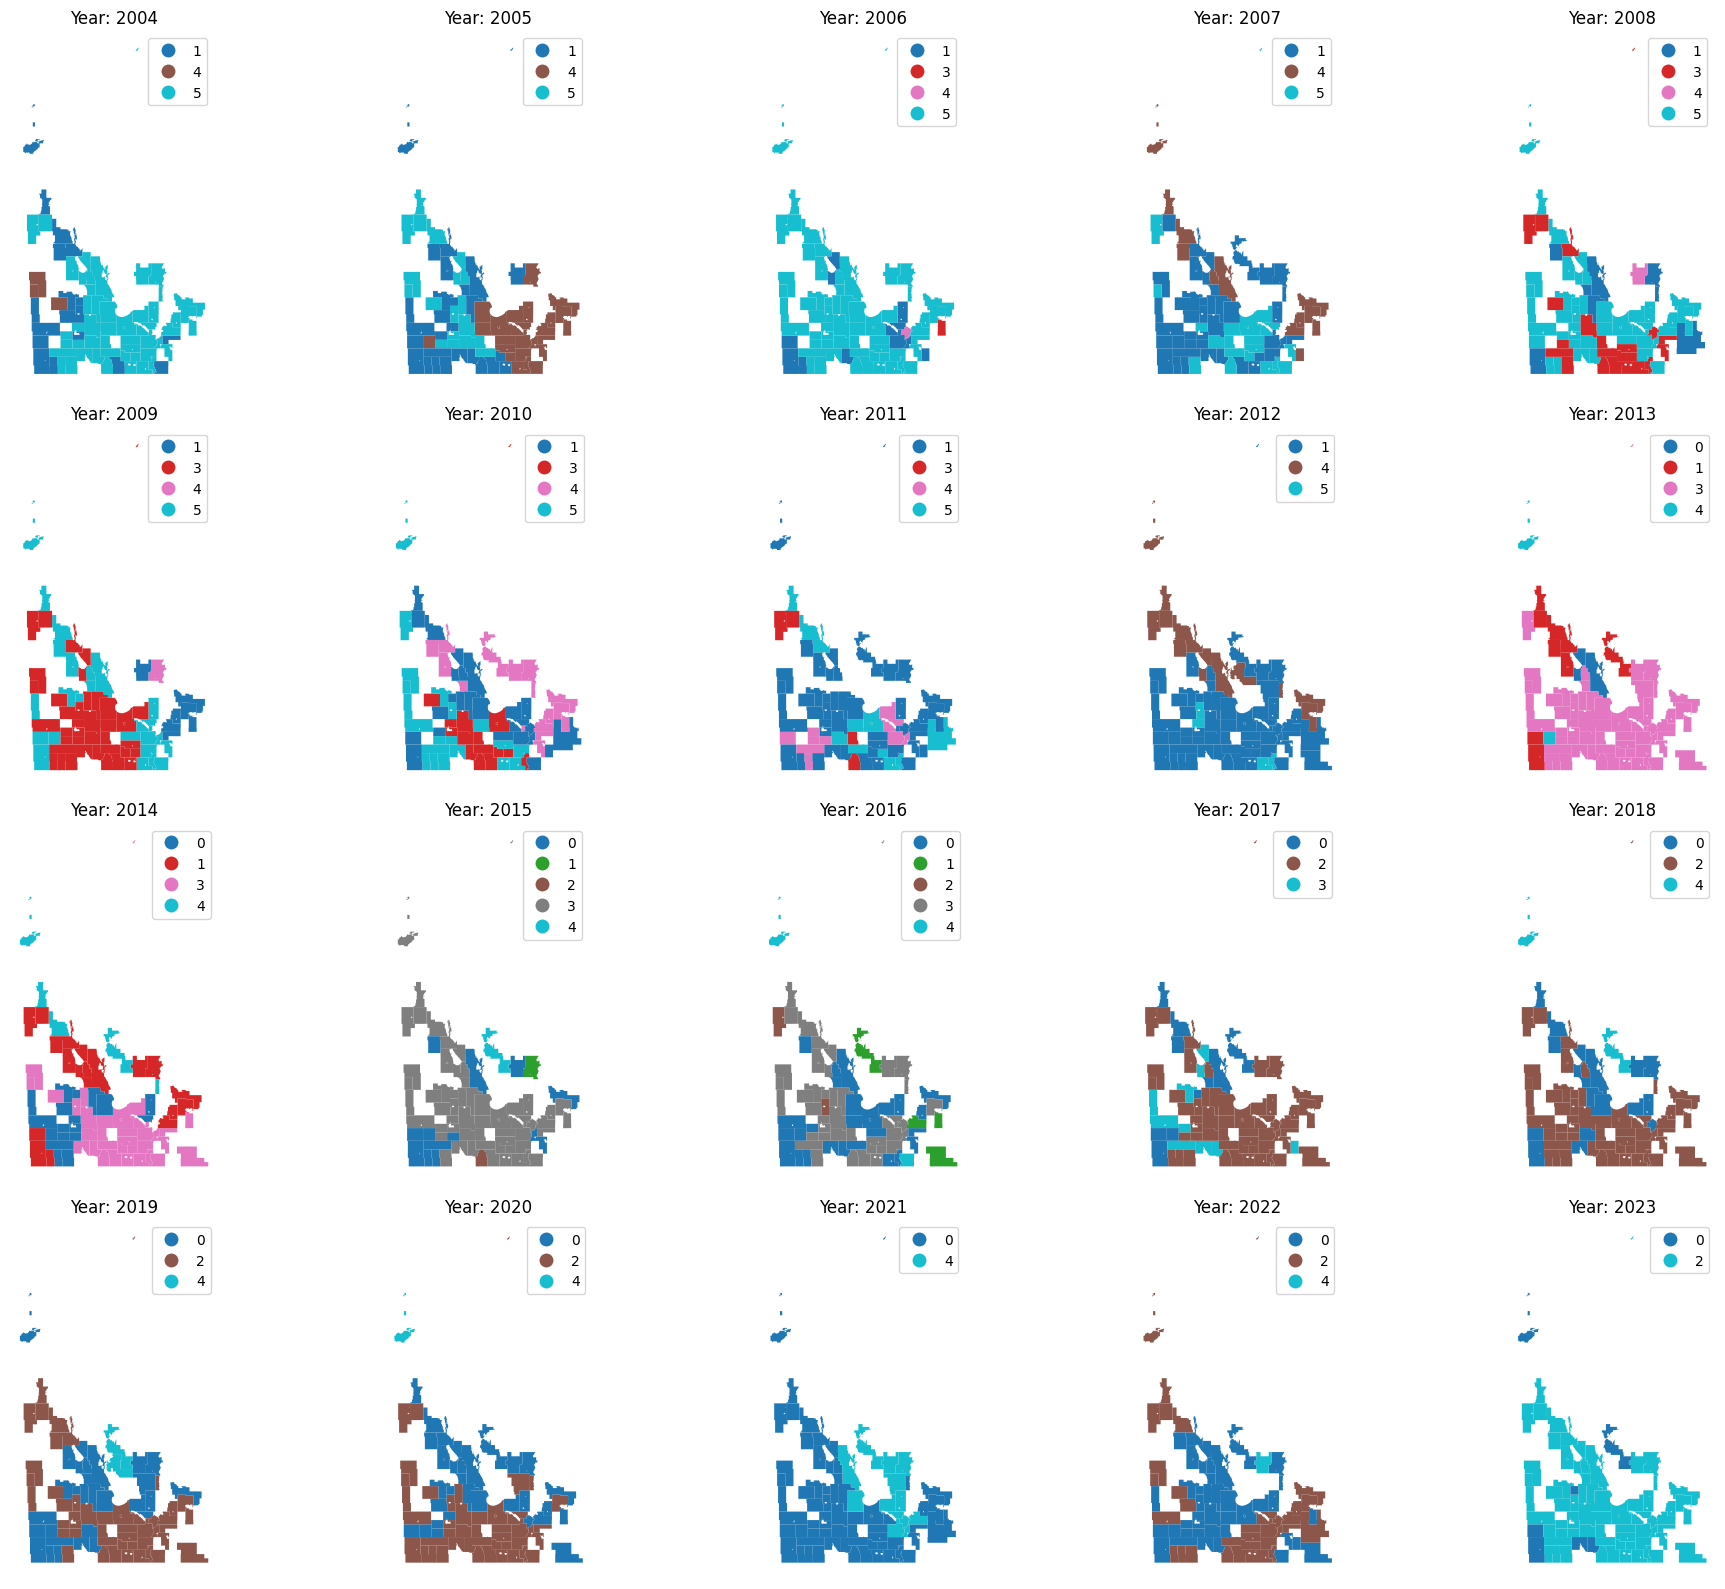

In [16]:

# Sort by Year to ensure years are ordered
gdf_Canolla_sorted = gdf_rm_yield_Canolla.sort_values(by='Year')

# Get the unique years
years = sorted(gdf_Canolla_sorted['Year'].unique())

# Create a 5x4 grid of subplots (5 columns, 4 rows)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop over the years and plot each year in a subplot
for i, year in enumerate(years):
    if i >= len(axes):  # Stop if we run out of subplots
        break
    # Filter the GeoDataFrame for the specific year
    yearly_data = gdf_Canolla_sorted[gdf_Canolla_sorted['Year'] == year]
    
    # Plot the data for the current year in the corresponding subplot
    yearly_data.plot(column='Cluster', categorical=True, legend=True, ax=axes[i])
    
    # Set the title as the year
    axes[i].set_title(f'Year: {year}')
    axes[i].axis('off')  # Hide axis for clarity

# Remove any unused subplots (if the number of years is less than the total subplots)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()